In [2]:
x

7

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np

from pdg.pdg import PDG
from pdg.rv import Variable as Var
from pdg.dist import RawJointDist as RJD, CPT

In [23]:
A = Var.alph("A", 3)
B = Var.alph("B", 2)
C = Var.alph("C", 3)

M = PDG()
M += A,B,C

M += CPT.make_random(A&B, C)
M += CPT.make_random(C, A)

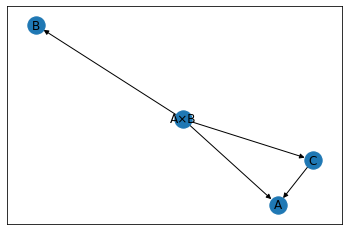

In [24]:
M.draw()

In [38]:
best = M.optimize_score(0)
M.score(best, gamma=0)

0.09430601763027362

In [69]:
M.dshape
n = np.prod(M.dshape)

In [70]:
mu = cp.Variable(n, nonneg=True)
p_special = best.data.reshape(-1)

In [71]:
t = { L : cp.Variable(n) for L in M.edges("l") }

In [77]:
print([p.to_numpy().shape for p in M.edges("P")])

[(6, 3), (6, 2), (6, 3), (3, 3)]


ValueError: Expressions of dimension greater than 2 are not supported.

In [76]:
tol_constraints = [
        cp.constraints.exponential.ExpCone(-t[L], mu, p.to_numpy().reshape(-1)) 
            for L,X,Y,p in M.edges("l,Xn,Yn,P")
    ]



ValueError: All arguments must have the same shapes. Provided arguments haveshapes ((18,), (18,), (12,))

In [46]:
sum(mu)

Expression(AFFINE, NONNEGATIVE, ())

In [60]:
prob = cp.Problem( cp.Minimize( sum(t) ), [ sum(mu) == 1, cp.constraints.exponential.ExpCone(-t, mu, p_special) ] )

In [66]:
prob.solve(tol=1E-12)

ValueError: Invalid keyword-argument 'tol'

In [62]:
prob.value

2.269466271616548e-09

In [63]:
t.value

array([-3.85685102e-07, -1.32302778e-07, -2.64633601e-07, -3.15668735e-07,
       -1.49579261e-07, -1.64668914e-07,  6.07089333e-07, -1.21766993e-06,
       -2.43687940e-07,  2.12011681e-10,  2.12011741e-10,  2.12011719e-10,
        2.69654817e-06,  8.07467119e-07, -3.38413468e-07, -4.30314393e-07,
       -2.36589249e-07, -2.30257820e-07])

In [64]:
mu.value

array([7.93619298e-02, 4.73115730e-02, 5.75627763e-03, 2.13553814e-03,
       2.92844487e-02, 5.65320095e-02, 1.21900531e-01, 3.13311352e-01,
       6.75353331e-03, 6.48174221e-10, 6.48173682e-10, 6.48173883e-10,
       1.83187207e-01, 1.24060432e-01, 1.42630598e-02, 5.23401643e-04,
       7.20694256e-03, 8.41175721e-03])

In [65]:
p_special

array([7.93623151e-02, 4.73117048e-02, 5.75654196e-03, 2.13585381e-03,
       2.92845978e-02, 5.65321738e-02, 1.21899924e-01, 3.13312571e-01,
       6.75377667e-03, 6.17248811e-16, 3.26219385e-17, 2.51405848e-16,
       1.83184520e-01, 1.24059624e-01, 1.42633979e-02, 5.23834019e-04,
       7.20717882e-03, 8.41198712e-03])